# Experiments with norms

We numerically compute the coefficients $c_1, c_2 \in {\mathbb R}^+$ of equivalent norms 

$$
c_1 \, \| u \|_B^2 \leq \| u \|_A^2 \leq c_2 \, \| u \|_B^2 \qquad \forall \, u \in V.
$$

We assume that both norms are generated by inner products, i.e.
$\| u \|_A^2 = A(u,u)$ and $\| u \|_B^2 = B(u,u)$.

To perform computations we need finite dimensional spaces. For function spaces $V$, we choose finite element sub-spaces of mesh-size $h$ and polynomial order $p$. We compute on a sequence of spaces $V_{h,p}$, to obtain $c_1(h,p)$ and $c_2(h,p)$. If these functions $c_1$ and $c_2$ seem to be bounded uniformly in $h$ and $p$, there is hope that the norm equivalence holds true also on the Sobolev space $V$.
This does NOT replace a mathematical analysis, but may help to decide if it is worth spending time to prove the estimate, or better search for a counter example.

By means of a basis for $V_h$, we can rewrite the norm equivalence in ${\mathbb R}^N$ with $N = \operatorname{dim} \, V_h$

$$
c_1 \, u^T B u \leq u^T A u \leq c_2 u^T B u \qquad \forall \, u \in {\mathbb R}^N,
$$

with representation matrices $A$ and $B$, or also with lower and upper bounds for the Rayleigh quotient

$$
c_1 \leq \frac{u^T A u}{u^T B u} \leq c_2 \qquad \forall \, u \in {\mathbb R}^N, \; u \neq 0
$$

Stationary points of the Rayleigh quotient are eigenvectors of the generalized eigenvalue-problem: find $\lambda \in {\mathbb R}$ and $u \in {\mathbb R}^N$ such that

$$
A u = \lambda B u.
$$

The eigenvalues $\lambda$ are the values of the quotient. In particular, the smallest and largest eigenvalues give sharp bounds for $c_1$ and $c_2$.


NGSolve provides the solver [LOBPCG](https://en.wikipedia.org/wiki/LOBPCG)
to compute a small number $m$ of eigenpairs corresponding to the smallest $m$, or largest $m$ eigenvalues. Both matrices must by symmetric, and $B$ must be also positive definite.

*Note:* The option for the largest eigenvalues was added 2024-03-16 (can use `pip install --upgrade --pre ngsolve`). For prior versions you have to swap the matrices $A$ and $B$, search for the smallest eigenvalue, and replace $\lambda$ by $1/\lambda$. 

In [1]:
from ngsolve import *
from netgen.occ import *
from ngsolve.webgui import Draw
import matplotlib.pyplot as plt

## Friedrichs' inequality

We want to find a sharp constant $c_F$ in Friedrich's inequality 
$$
\| u \|_{L_2} \leq c_F \| \nabla u \|_{L_2} \quad \forall \, v \in H_{0,D}^1(\Omega),
$$
with $\Omega = (0,1)^2$, and Dirichlet on the left and on the right side of the domain.

$$
c_F^2 =
\sup_{u \in H_{0,D}^1} \frac{\| u \|_{L_2}^2}{ \| \nabla u \|_{L_2}^2 }
$$

In [2]:
def SetupProblem(h,p):
    mesh = Mesh(unit_square.GenerateMesh(maxh=h))
    fes = H1(mesh, order=p, dirichlet="left|right")
    u,v = fes.TnT()
    L2Norm = BilinearForm(u*v*dx).Assemble().mat
    H1SemiNorm = BilinearForm(grad(u)*grad(v)*dx).Assemble().mat
    pre = Projector(fes.FreeDofs(), range=True)
    return L2Norm, H1SemiNorm, pre, fes

In [3]:
A,B,P,fes = SetupProblem(0.1, 5)
evals,evecs = solvers.LOBPCG(A, B, pre=P, num=5, maxit=200, largest=True, printrates=False)
print ("eigenvalues: ", list(evals))
print ("Friedrichs' constant: c_F = ", sqrt(evals[-1]))
print ("inverse of Friedrichs' constant: 1/c_F = ", 1/sqrt(evals[-1]))

gfu = GridFunction(fes)
gfu.vec.data = evecs[-1]
gfu.vec.data  /= Integrate(gfu*dx, fes.mesh) # normalize eigenfunction

eigenvalues:  [0.02026423260401859, 0.020264234576601207, 0.02533029173591055, 0.05066057588433866, 0.10132093820158766]
Friedrichs' constant: c_F =  0.31830950064612845
inverse of Friedrichs' constant: 1/c_F =  3.14159645869861


In [4]:
Draw (gfu);

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

We compute on a sequence of spaces, and observe that the maximal eigenvalue converges very fast. This is in agreement to Friedrichs' inequality which we have proven above.

In [5]:
lams = []
for p in range(1,6):
    A,B,P,fes = SetupProblem(0.1, p)
    evals,evecs = solvers.LOBPCG(A, B, pre=P, num=5, maxit=200, largest=True, printrates=False)
    lams.append([p,evals[-1]])

[[1, 0.1006620781684165], [2, 0.10132037983620126], [3, 0.10132118307694851], [4, 0.10132118070154268], [5, 0.10132105302197744]]


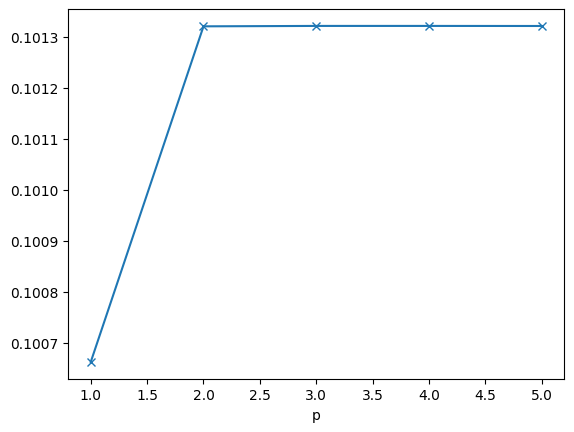

In [7]:
print (lams)
plt.xlabel("p")
plt.plot(*zip(*lams), '-x');

### Inverse estimates

Now we search for the other bound for the norm equivalence, i.e.

$$
\| \nabla u_h \|_{L_2(\Omega)} \leq c(h,p) \, \| u_h \|_{L_2(\Omega)} \qquad \forall \, u_h \in V_{hp},
$$

where the (squared) sharp bound is the maximizer of the Rayleigh quotient

$$
c(h,p)^2 = \sup_{u \in V_{hp}} \frac{\|\nabla u\|^2_{L_2}}{\|u\|_{L_2}^2}
$$

[[4.0, 501.7907346494361], [8.0, 2135.5622834775504], [16.0, 7804.143924722657], [32.0, 34633.51884502969], [64.0, 133659.64804621149]]


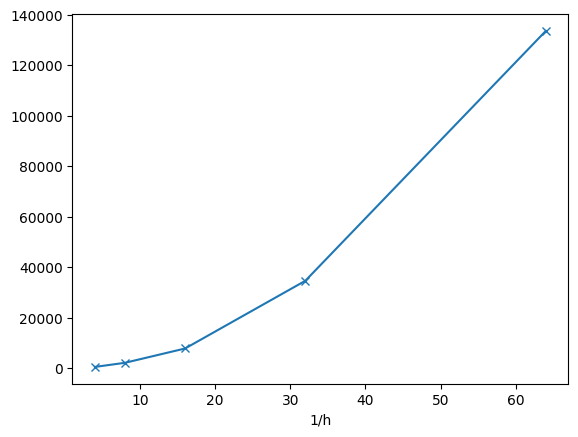

In [9]:
lams = []
for level in range(2,7):
    h = 0.5**level
    A,B,P,fes = SetupProblem(h, 1)
    evals,evecs = solvers.LOBPCG(B, A, pre=P, num=5, maxit=200, printrates=False, largest=True)
    lams.append([1/h,evals[-1]])

print (lams)
plt.xlabel("1/h")
plt.plot(*zip(*lams), '-x');

[[1, 653.1789330005988], [2, 3530.634916543759], [3, 9088.119997276694], [4, 16984.083364843955], [5, 25163.48156999712]]


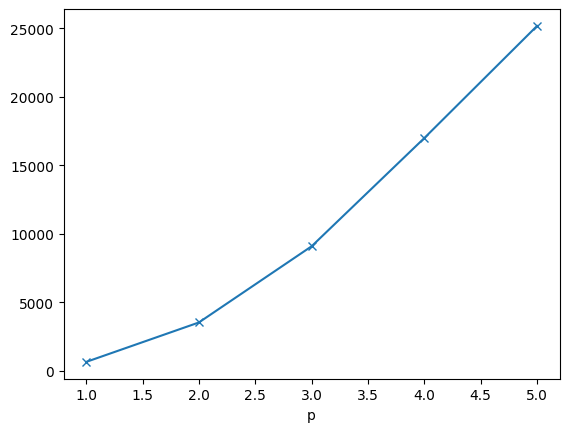

In [11]:
lammins = []
for p in range(1,6):
    A,B,P,fes = SetupProblem(0.2, p)
    evals,evecs = solvers.LOBPCG(B, A, pre=P, num=5, maxit=200, printrates=False, largest=True)
    lammins.append([p,evals[-1]])

print (lammins)
plt.xlabel("p")
plt.plot(*zip(*lammins), '-x');

We clearly see that now the largest eigen-values grow as we refine the mesh, or increase the order. On every finite dimensional space the estimate $\| \nabla u \|_{L_2} \leq c \| u \|_{L_2}$, but the constant grows with $1/h$ and $p$. This is called an *inverse* estimate.


## Trace inequality

We have proven there exists a continuous trace operator $\operatorname{tr} H^1(\Omega) \rightarrow L_2(\partial \Omega)$, its norm is

$$
\| \operatorname{tr} \|^2 = \sup_{u \in H^1} 
\frac{\| \operatorname{tr} u \|_{L_2(\Gamma_D)}^2} {\|u\|_{H^1}^2}
$$

We verify this numerically:

In [12]:
def SetupTraceProblem(h,p):
    mesh = Mesh(unit_square.GenerateMesh(maxh=h))
    fes = H1(mesh, order=p)
    u,v = fes.TnT()
    H1Norm = BilinearForm(u*v*dx+grad(u)*grad(v)*dx).Assemble().mat
    L2GammaNorm = BilinearForm(u*v*ds("left"), check_unused=False).Assemble().mat
    pre = Projector(fes.FreeDofs(), range=True)
    return L2GammaNorm, H1Norm, pre, fes

[[1, 1.306377152389473], [2, 1.3130323762459357], [3, 1.3130352795102553], [4, 1.313035285299675], [5, 1.3130352238771232]]


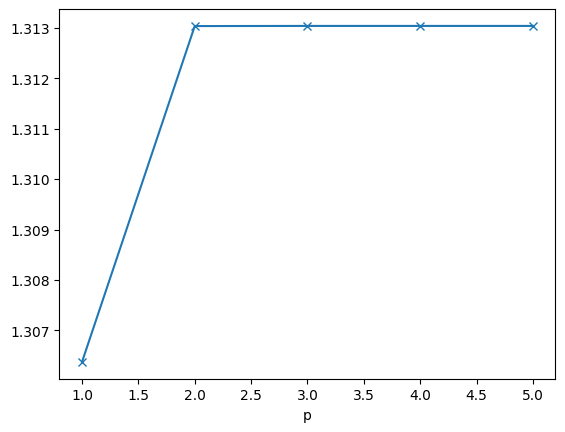

In [14]:
lams = []
for p in range(1,6):
    A,B,P,fes = SetupTraceProblem(0.3, p)
    evals,evecs = solvers.LOBPCG(A, B, pre=P, num=5, maxit=200, printrates=False, largest=True)
    lams.append([p,evals[-1]])

print (lams)
plt.xlabel("p")
plt.plot(*zip(*lams), '-x');

## Poincaré inequality

We are looking for the few lowest critical points / eigenvalues of 

$$
\frac{\| \nabla u \|_{L_2}^2}{ \| u \|_{L_2}^2}
$$

The smallest eigenvalue $\lambda_1$ is 0, with the eigenspace being the constant functions. The second-smallest eigenvalue $\lambda_2$ is the minimum of the Rayleigh quotient, taken the at the $L_2$-orthogonal complement to the first eigen-space, i.e. the constants. Thus we get

$$
\| u \|_{L_2}^2 \leq \lambda_2 \, \| \nabla u \|_{L_2}^2 \qquad \forall \, u \in H^1, \; (u,1)_{L_2} = 0
$$


In [18]:
def SetupPoincareProblem(h,p):
    mesh = Mesh(unit_square.GenerateMesh(maxh=h))
    fes = H1(mesh, order=p)
    u,v = fes.TnT()
    H1SemiNorm = BilinearForm(grad(u)*grad(v)*dx).Assemble().mat
    L2Norm = BilinearForm(u*v*dx).Assemble().mat
    pre = Projector(fes.FreeDofs(), range=True)
    return H1SemiNorm, L2Norm, pre, fes

[[1, 3.243526026376932], [2, 3.1427436944465015], [3, 3.1416015339539203], [4, 3.141592936314376], [5, 3.1415934955140496]]


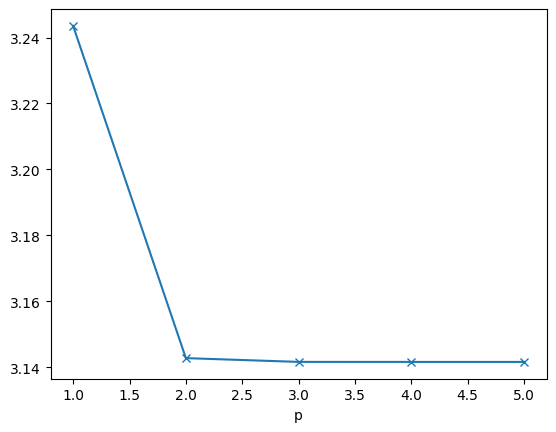

In [22]:
lams = []
for p in range(1,6):
    A,B,P,fes = SetupPoincareProblem(0.3, p)
    evals,evecs = solvers.LOBPCG(A, B, pre=P, num=5, maxit=200, printrates=False, largest=False)
    lams.append([p,sqrt(evals[1])])

print (lams)
plt.xlabel("p")
plt.plot(*zip(*lams), '-x');

## Korn's inequality

The symmetrized gradient differential operator on $[H^1(\Omega)]^d$

$$
\varepsilon(u) := \tfrac{1}{2} \big( \nabla u + (\nabla u)^T \big)
$$

plays an important role in solid mechanics. Korn's first inequality states that, together with an $L_2$-norm, it provides an equivalent norm:

$$
\| u \|_{L_2}^2 + \| \varepsilon(u) \|_{L_2}^2 \simeq \| u \|_{H^1}^2 
\qquad \forall \, u \in [H^1(\Omega)]^d
$$

From Tartar's theorem follows that the kernel of $\varepsilon(.)$ is finite dimensional. If the kernel is blocked by essential boundary conditions, the semi-norm becomes a norm.

However, the norm equivalence may depend on the shape of the domain. We perform experiments on the rectangle $(0,L) \times (0,1)$, with Dirichlet boundary conditions at the left side.

In [30]:
def SetupKorn(h,p,L):
    shape = Rectangle(L,1).Face()
    shape.edges.Min(X).name="left"
    mesh = Mesh(OCCGeometry(shape,dim=2).GenerateMesh(maxh=h))
    fes = VectorH1(mesh, order=p, dirichlet="left")
    u,v = fes.TnT()
    EpsSemiNorm = BilinearForm(InnerProduct(Sym(Grad(u)),Sym(Grad(v)))*dx).Assemble().mat
    H1SemiNorm = BilinearForm(InnerProduct(Grad(u),Grad(v))*dx).Assemble().mat
    pre = H1SemiNorm.Inverse(freedofs=fes.FreeDofs(), inverse="sparsecholesky")
    return EpsSemiNorm, H1SemiNorm, pre, fes    

In [31]:
A,B,P,fes = SetupKorn(0.3,3,5)
evals,evecs = solvers.LOBPCG(A, B, pre=P, num=5, maxit=200, printrates=False)
print (evals[0])
gfu = GridFunction(fes)
gfu.vec.data = evecs[0]
Draw (gfu, deformation=True);

0.004064491905451254


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…